In [1]:
# Hyperparameters
debug = False
MIN = 1 # n-gram
MAX = 1 # n-gram
MAX_DF = 0.6
HASH_POWER = 10 # hash to 2**HASH_POWER features

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import re
import nltk
import os
import xgboost as xgb
import datetime

from xgboost import XGBClassifier
from tqdm import tqdm
from bs4 import BeautifulSoup
from summa import keywords
from summa.summarizer import summarize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from time import strptime
from cup01 import *

In [3]:
if not os.path.exists("output/") : os.mkdir("output/")

## 一. 資料前處理
首先先引入dataset

### 1.1 清掉所有的html tag

In [4]:
def preprocessor(text):
    # remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    # regex for matching emoticons, keep emoticons, ex: :), :-P, :-D
    r = '(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(r, text)
    text = re.sub(r, '', text)
    
    # convert to lowercase and append all emoticons behind (with space in between)
    # replace('-','') removes nose of emoticons
    text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-','')
    return text

### 1.2 定義tokenize+波特詞幹還原演算法+刪除停用字

In [5]:
nltk.download('stopwords')
stop = stopwords.words('english')
stop = stop + extra_stopwords()

def tokenizer_stem_nostop(text):
    porter = PorterStemmer()
    return [porter.stem(w) for w in re.split('\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]

print(tokenizer_stem_nostop('runners like running and thus they run')) # Test if it works

['runner', 'like', 'run', 'thu', 'run']


[nltk_data] Downloading package stopwords to /home/benny/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1.3 分析文章基本性質
例如作者,圖片數量等等

In [6]:
df1 = pd.read_csv('./input/train.csv')
df2 = pd.read_csv('./input/test.csv')
df2['Popularity'] = np.zeros(len(df2))
df = pd.concat([df1,df2])
train_length = len(df1)
test_length = len(df2)
del df1, df2

In [7]:
df.head(5)

,Id,Popularity,Page content
0,0,-1.0,"<html><head><div class=""article-info""> <span c..."
1,1,1.0,"<html><head><div class=""article-info""><span cl..."
2,2,1.0,"<html><head><div class=""article-info""><span cl..."
3,3,-1.0,"<html><head><div class=""article-info""><span cl..."
4,4,-1.0,"<html><head><div class=""article-info""><span cl..."


In [8]:
df_train_contents = df['Page content'].values.tolist()

In [9]:
days, pub_days, channels, img_counts, topics, authors, titles, social_media_counts, \
contents, num_hrefs, num_self_hrefs \
= get_all_datas(df_train_contents)

In [10]:
rate_positive_words, rate_negative_words, avg_positive_polarity, min_positive_polarity, max_positive_polarity, \
avg_negative_polarity, min_negative_polarity, max_negative_polarity \
= get_word_sentiment_features(contents)

KeyboardInterrupt: 

In [ ]:
n_tokens_titles, n_tokens_contents, n_unique_tokens, n_non_stop_words, n_non_stop_unique_tokens \
= get_some_n_features(titles, contents)

In [ ]:
global_sentiment_polarity, global_subjectivity, title_subjectivity_list, title_sentiment_polarity_list, \
abs_title_subjectivity, abs_title_sentiment_polarity \
= get_sentiment_features(titles, contents)

combine the properties

In [ ]:
df = pd.DataFrame({'Page content':df_train_contents,
                   'Id':df.Id[:],
                   'Popularity':df.Popularity[:],
                   'topic':topics,
                   'channel':channels,
                   'weekday':days,
                   'pub_date' : pub_days,
                   'author':authors,
                   'img count':img_counts,
                   'title':titles,
                   'content':contents,
                   'media count': social_media_counts,
                   'n_tokens_title' : n_tokens_titles,
                   'n_tokens_content': n_tokens_contents,
                   'n_unique_tokens' : n_unique_tokens,
                   'n_non_stop_words': n_non_stop_words,
                   'n_non_stop_unique_tokens': n_non_stop_unique_tokens,
                   'num_hrefs' : num_hrefs,
                   'num_self_hrefs' : num_self_hrefs,
                   'global_sentiment_polarity' : global_sentiment_polarity,
                   'global_subjectivity' : global_subjectivity,
                   'title_subjectivity' : title_subjectivity_list,
                   'title_sentiment_polarity' : title_sentiment_polarity_list,
                   'abs_title_subjectivity' : abs_title_subjectivity,
                   'abs_title_sentiment_polarity' : abs_title_sentiment_polarity,
                   'rate_positive_words' : rate_positive_words,
                   'rate_negative_words' : rate_negative_words,
                   'avg_positive_polarity' : avg_positive_polarity,
                   'min_positive_polarity' : min_positive_polarity,
                   'max_positive_polarity' : max_positive_polarity,
                   'avg_negative_polarity' : avg_negative_polarity,
                   'min_negative_polarity' : min_negative_polarity,
                   'max_negative_polarity' : max_negative_polarity})

### 1.4 時間

In [ ]:
df['day_of_month'] = df['pub_date'].apply(lambda x: int(x.split()[1]))
df['month'] = df['pub_date'].apply(lambda x: strptime(x.split()[2], '%b').tm_mon)
df['hour'] = df['pub_date'].apply(lambda x: strptime(x.split()[4], '%X')[3])

In [ ]:
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x ==' Sat' or x == ' Sun' else 0)

In [ ]:
del df_train_contents, df['pub_date']

### 1.5 產生關鍵字

In [ ]:
tqdm.pandas()
df['Page content'] = df['Page content'].progress_apply(preprocessor) # 此步驟約要花五分鐘

In [ ]:
tqdm.pandas()
df['keywords'] = df['Page content'].progress_apply(tokenizer_stem_nostop)

In [ ]:
df['keywords'] = df['keywords'].progress_apply(lambda x: ' '.join(x))

In [ ]:
tqdm.pandas()
df['keywords'] = df['keywords'].progress_apply(lambda x: keywords.keywords(x).replace('\n', ' '))

### 1.6 作者評價

In [ ]:
col = 'author'
df2 = df.iloc[:train_length].groupby(f'{col}').mean().reset_index().sort_values(by='Popularity', ascending=False)\
    [[f'{col}', 'Popularity']]
df2.columns=[f'{col}', 'avg_popularity']

In [ ]:
author_avg_score = {}
for i, row in df2.iterrows():
    author_name = row['author']
    score = row['avg_popularity']
    author_avg_score[author_name] = score

In [ ]:
df['author_popularity'] = df['author'].apply(lambda x: author_avg_score[x] if x in author_avg_score else 0.0)

In [ ]:
del df2

In [ ]:
df.head(5)

In [ ]:
df.to_csv('./input/input_feature.csv')

## 二. 特徵選擇

In [ ]:
df = pd.read_csv('./input/input_feature.csv')

### 2.1 找出頻率最高的詞

In [ ]:
count = CountVectorizer(ngram_range=(1, 1), # (MIN, MAX)
                        preprocessor=preprocessor,
                        tokenizer=tokenizer_stem_nostop)
count.fit(["YEAH TIGER", "FIBER WIPER"]) # need to fit something first

In [ ]:
doc = df['Page content']
doc_bag = count.fit_transform(doc).toarray()

print("[most frequent vocabularies]")
bag_cnts = np.sum(doc_bag, axis=0)
top = 10
# [::-1] reverses a list since sort is in ascending order
for tok, v in zip(count.inverse_transform(np.ones(bag_cnts.shape[0]).reshape(1, -1))[0][bag_cnts.argsort()[::-1][:top]], 
                  np.sort(bag_cnts)[::-1][:top]):
    print('{}: {}'.format(tok, v))

### 2.2 基於整個文本的TF-IDF

利用前面所定義的前處理方法產生tf-idf向量

In [ ]:
doc = df['Page content']
tfidf = TfidfVectorizer(ngram_range=(MIN, MAX), 
                        preprocessor=preprocessor, 
                        tokenizer=tokenizer_stem_nostop, 
                        max_df=MAX_DF, 
                        min_df=0.0001)
tfidf.fit(doc)
doc_tfidf = tfidf.transform(doc).toarray()

In [ ]:
print(doc_tfidf.shape)

In [ ]:
np.savetxt("tfidf.csv", doc_tfidf, delimiter=",")

接著調查idf分數以及tf-idf值最大的10個單字

In [ ]:
top = 10
# get idf score of vocabularies
idf = tfidf.idf_
print('[vocabularies with smallest idf scores]')
sorted_idx = idf.argsort()

for i in range(top):
    print('%s: %.2f' %(tfidf.get_feature_names()[sorted_idx[i]], idf[sorted_idx[i]]))


tfidf_sum = np.sum(doc_tfidf, axis=0)
print("\n[vocabularies with highest tf-idf scores]")
for tok, v in zip(tfidf.inverse_transform(np.ones(tfidf_sum.shape[0]).reshape(1, -1))[0][tfidf_sum.argsort()[::-1]][:top], \
                        np.sort(tfidf_sum)[::-1][:top]):
    print('{}: {}'.format(tok, v))

In [ ]:
del doc_tfidf

### 2.3 基於關鍵字的tf-idf

In [ ]:
doc = df['keywords']
tfidf = TfidfVectorizer(ngram_range=(1, 1), 
                        preprocessor=preprocessor, 
                        tokenizer=tokenizer_stem_nostop)
tfidf.fit(doc)
doc_tfidf = tfidf.transform(doc).toarray()

In [ ]:
print(doc_tfidf.shape)

In [ ]:
top = 10
# get idf score of vocabularies
idf = tfidf.idf_
print('[vocabularies with smallest idf scores]')
sorted_idx = idf.argsort()

for i in range(top):
    print('%s: %.2f' %(tfidf.get_feature_names()[sorted_idx[i]], idf[sorted_idx[i]]))


tfidf_sum = np.sum(doc_tfidf, axis=0)
print("\n[vocabularies with highest tf-idf scores]")
for tok, v in zip(tfidf.inverse_transform(np.ones(tfidf_sum.shape[0]).reshape(1, -1))[0][tfidf_sum.argsort()[::-1]][:top], \
                        np.sort(tfidf_sum)[::-1][:top]):
    print('{}: {}'.format(tok, v))

In [ ]:
del doc_tfidf

### 2.4 Feature Hashing
hash words to 1024 or 2048 buckets

In [ ]:
doc = df['keywords']
hashvec = HashingVectorizer(n_features=2**HASH_POWER)

no .fit needed for HashingVectorizer, since it's defined by the hash function. transform sentences to vectors of dimension 1024

In [ ]:
doc_hash = hashvec.transform(doc).toarray()
print(doc_hash.shape)

In [ ]:
doc = df['title']
hashvec = HashingVectorizer(n_features=2**HASH_POWER)

In [ ]:
doc_hash_title = hashvec.transform(doc).toarray()
print(doc_hash_title.shape)

### 2.5 One hot Encoding

In [ ]:
# channel
channel_ohe = OneHotEncoder(handle_unknown='ignore')
channel_str = channel_ohe.fit_transform(df['channel'].values.reshape(-1,1)).toarray()
print(channel_str.shape)

# weekday
weekday_ohe = OneHotEncoder(handle_unknown='ignore')
weekday_str = weekday_ohe.fit_transform(df['weekday'].values.reshape(-1,1)).toarray()
print(weekday_str.shape)

# ohe author
author_ohe = OneHotEncoder(handle_unknown='ignore')
author_str = author_ohe.fit_transform(df['author'].values.reshape(-1,1)).toarray()
print(author_str.shape)

把所有特徵給組合起來

In [ ]:
img_count = df['img count'].values.reshape(-1,1)
media_count = df['media count'].values.reshape(-1,1)

In [ ]:
def flatten(t):
    return [item for sublist in t for item in sublist]

df_X = []
for i in tqdm(range(len(channel_str))):
    temp = []
    temp.append(img_count[i])
    temp.append(media_count[i])
    temp.append(channel_str[i])
    temp.append(weekday_str[i])
    temp.append(author_str[i])
    temp.append(doc_hash[i])
    temp.append(doc_hash_title[i])
    temp = flatten(temp)
    temp.append(df['day_of_month'][i])
    temp.append(df['month'][i])
    temp.append(df['hour'][i])
    temp.append(df['n_tokens_title'][i])
    temp.append(df['n_tokens_content'][i])
    temp.append(df['n_unique_tokens'][i])
    temp.append(df['n_non_stop_words'][i])
    temp.append(df['n_non_stop_unique_tokens'][i])
    temp.append(df['num_hrefs'][i])
    temp.append(df['num_self_hrefs'][i])
    temp.append(df['global_sentiment_polarity'][i])
    temp.append(df['global_subjectivity'][i])
    temp.append(df['title_subjectivity'][i])
    temp.append(df['title_sentiment_polarity'][i])
    temp.append(df['abs_title_subjectivity'][i])
    temp.append(df['abs_title_sentiment_polarity'][i])
    temp.append(df['rate_positive_words'][i])
    temp.append(df['rate_negative_words'][i])
    temp.append(df['avg_positive_polarity'][i])
    temp.append(df['min_positive_polarity'][i])
    temp.append(df['max_positive_polarity'][i])
    temp.append(df['avg_negative_polarity'][i])
    temp.append(df['min_negative_polarity'][i])
    temp.append(df['max_negative_polarity'][i])
    temp.append(df['is_weekend'][i])
    temp.append(df['author_popularity'][i])
    df_X.append(temp)
    del temp

df_y = df['Popularity'].to_numpy()

In [ ]:
del df, doc_hash, img_count, media_count, channel_str, weekday_str, author_str

In [ ]:
print(len(df_X),len(df_X[0]))

存成csv檔案就不用再重跑之前的code了

In [24]:
pd.DataFrame(df_X).to_csv("./input/X_data.csv", index=False, header=False)
pd.DataFrame(df_y).to_csv("./input/y_data.csv", index=False, header=False)

生成training set和testing set

## 三. 模型訓練
直接從這裡開始跑

In [3]:
df_X = pd.read_csv('./input/X_data.csv', header=None).values
df_y = pd.read_csv('./input/y_data.csv', header=None).values

In [ ]:
X_submit = df_X.iloc[train_length:]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(df_X_train[:train_length], 
                                                    df_y_train[:train_length], 
                                                    test_size=0.2)

In [46]:
del df_X
del df_y

### 3.1 繪製解釋變異數圖形

In [47]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [48]:
cov_mat = np.cov(X_train_std.T) # 計算特徵值
eigen_vals, _ = np.linalg.eig(cov_mat)

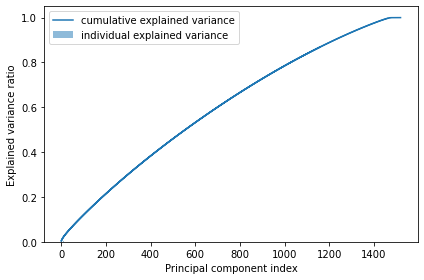

In [49]:
# 把explained variance(lambda i / lambda和)由大排到小
tot = sum(eigen_vals)
var_exp = np.array([(i / tot) for i in sorted(eigen_vals, reverse=True)])
cum_var_exp = np.cumsum(var_exp) # 計算解釋變異數

# 繪圖
plt.bar(range(len(eigen_vals)), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(len(eigen_vals)), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('images/05_02.png', dpi=300)
plt.show()

In [50]:
del X_train_std, X_test_std

### 3.2 Logistic Regression

In [51]:
pipe_lr = make_pipeline(StandardScaler(),
                        #PCA(n_components=1000),
                        LogisticRegression(random_state=0))

### 3.3 xgboost

In [52]:
X_train_xgb = np.array(X_train)
X_test_xgb = np.array(X_test)
y_train_xgb = y_train
y_train_xgb[y_train==-1] = 0
y_test_xgb = y_test
y_test_xgb[y_test==-1] = 0
d_train = xgb.DMatrix(X_train_xgb, y_train_xgb)
d_test = xgb.DMatrix(X_test_xgb)

In [53]:
xgb_params = {'eta': 0.05, 
              'max_depth': 4, 
              'subsample': 0.7 ,
              'colsample_bytree': 0.7,
              'min_child_weight' : 4,
              'objective': 'binary:logistic', 
              'eval_metric': 'auc',
              'alpha': 0.005,
             }
xgb_model = xgb.XGBClassifier(**xgb_params)
xgb_params = xgb_model.get_xgb_params()

## 四. 參數調整

### 4.1 Logistic Regression

In [ ]:
import warnings
warnings.filterwarnings("ignore")

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0] 
param_grid = [{'logisticregression__C': param_range, 
               'logisticregression__penalty': ['l2'],
               'logisticregression__class_weight': ['balanced', None],
               'logisticregression__solver': ['saga', 'lbfgs']}]

# 使用網格搜尋法
gs = GridSearchCV(estimator=pipe_lr, 
                  param_grid=param_grid, 
                  scoring='roc_auc', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train.ravel())

# 輸出結果
print(gs.best_score_) 
print(gs.best_params_) # 最佳參數組合

In [ ]:
clf = gs.best_estimator_ # 取得剛剛算出的最佳參數
clf.fit(X_train, y_train) # 用這個參數train出model

### 4.2 XGB

In [ ]:
cvresult = xgb.cv(xgb_params, 
                  d_train, 
                  num_boost_round=1000, 
                  verbose_eval=10, 
                  nfold=5, 
                  metrics=['auc'],
                  early_stopping_rounds=50, 
                  stratified=True)

In [ ]:
xgb_model.set_params(n_estimators=cvresult.shape[0])

In [ ]:
xgb_model.fit(X_train_xgb, y_train_xgb, eval_metric='auc', verbose=True)

## 五. 結果預測

### 5.1 Logistic Regression

In [14]:
y_pred = clf.predict(X_test)
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))
scores = cross_val_score(estimator=clf, 
                         X=X_test, 
                         y=y_test, 
                         cv=10, 
                         verbose = 0,
                         scoring='roc_auc')
print('AUC score: %.3f (+/-%.3f)' % (scores.mean(), scores.std()))

Test Accuracy: 0.563
AUC score: 0.550 (+/-0.021)


### 5.2 XGB

In [27]:
y_pred = xgb_model.predict_proba(X_test_xgb)[:,1]
print('Test Accuracy: %.3f' % xgb_model.score(X_test_xgb, y_test_xgb))
scores = cross_val_score(estimator=xgb_model, 
                         X=X_test_xgb, 
                         y=y_test_xgb, 
                         cv=10, 
                         verbose = 0,
                         scoring='roc_auc')
print('AUC score: %.3f (+/-%.3f)' % (scores.mean(), scores.std()))

Test Accuracy: 0.570
AUC score: 0.597 (+/-0.020)


In [28]:
y_pred

array([0.45412835, 0.5023792 , 0.48275134, ..., 0.45412835, 0.45297825,
       0.43467173], dtype=float32)

## 六. 繳交結果

In [29]:
X_submit = np.array(X_submit)

In [33]:
y_submit = xgb_model.predict_proba(X_submit)[:,1]

In [34]:
y_submit 

array([0.30764163, 0.30158874, 0.3070396 , ..., 0.3197558 , 0.31357256,
       0.3070396 ], dtype=float32)

In [26]:
df_submission = pd.read_csv('./output/sample_submission.csv')
df_submission['Popularity'] = y_pred
df_submission.to_csv('./output/submit.csv', index=False)